In [1]:
import sys
import os
REPO_PATH = '/Users/jacquesdechalendar/Box Sync/Benson_Lab/grid/publications/ne/code_submission'
#REPO_PATH = os.getenv('REPO_PATH')
sys.path.insert(0, REPO_PATH+"/py_notebooks/")
figFolder = os.path.join(REPO_PATH, "py_notebooks/figures/")

import pandas as pd
import numpy as np
import xlrd

from datetime import timedelta
import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import plotting

# units
import myunits
u = myunits.units()
GJ_per_mmbtu = u['GJ_per_mmbtu']
kwh_per_mmbtu = u['kwh_per_mmbtu']

kWh_per_tonhr = u['kWh_per_tonhr']
GJ_per_kwh = u['GJ_per_kwh']
GJ_per_ton = kWh_per_tonhr * GJ_per_kwh

cm_to_in = 0.393701
single_col = 8.3
double_col = 17.1

plotting.reset_fonts(SMALL_SIZE=9, MEDIUM_SIZE=9, BIGGER_SIZE=9)
from matplotlib import rc

rc('text', usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],
             'size':8})

In [2]:
def plot_energy_in_hmaps(df):
    
    fig = plt.figure(figsize=(single_col*cm_to_in,1.2))
    ax = fig.add_axes([0, 0, 1, 1])
    plotting.plotHeatmap(df, "CW_GJ", fillValue=0,
                         cbar_label="Cooling (GJ)", scaling=1, fig=fig,
                         ax=ax, ynTicks=4, xnTicks=4, vmin=40,vmax=300,
                         transpose=True, cbar_nTicks=5)

    lab = plt.xlabel("day")
    plt.savefig(figFolder+"cooling_in.eps", format='eps', dpi=200,
                bbox_extra_artists=(lab,), bbox_inches='tight')

    fig = plt.figure(figsize=(single_col*cm_to_in,1.2))
    ax = fig.add_axes([0, 0, 1, 1])
    plotting.plotHeatmap(df, "HW_GJ", fillValue=0,
                         cbar_label="Heating (GJ)", scaling=1, fig=fig,
                         ax=ax, ynTicks=4, xnTicks=4, vmin=20,vmax=200,
                         transpose=True, cbar_nTicks=5)
    lab = plt.xlabel("day")
    plt.savefig(figFolder + "heating_in.eps", format='eps', dpi=200,
                bbox_extra_artists=(lab,), bbox_inches='tight')

    fig = plt.figure(figsize=(single_col*cm_to_in,1.2))
    ax = fig.add_axes([0, 0, 1, 1])
    plotting.plotHeatmap(df, "CampusElec_GJ", fillValue=0,
                         cbar_label="Electricity (GJe)", scaling=1,
                         fig=fig, ax=ax, ynTicks=4, xnTicks=4, vmin=70,
                         vmax=115, transpose=True, cbar_nTicks=5)
    lab = plt.xlabel("day")
    #plt.tight_layout()
    plt.savefig(figFolder+"power_in.eps", format='eps', dpi=200,
                bbox_extra_artists=(lab,), bbox_inches='tight')


def figure1(df):

    df["date"] = df.index.date
    df_daily = df.groupby("date").sum()

    df_daily["HRC_daily_CW"] = df_daily.apply(lambda x:
                                              min(x.CW_GJ, x.HW_GJ/1.3),
                                              axis=1)

    df_daily["HRC_daily_HW"] = 1.37*df_daily.HRC_daily_CW

    fig = plt.figure(figsize=(double_col*cm_to_in,2))
    ax=plt.gca()
    ax.fill_between(df_daily.index, 0, df_daily.CW_GJ, label="Cold")

    #plt.plot(-df_daily.HW_GJ/GJ_per_mmbtu)
    ax.fill_between(df_daily.index, 0, -df_daily.HW_GJ, label="Hot")
    #plt.ylim([0, 4800])

    print(df_daily.HW_GJ.sum())
    print(df_daily.CW_GJ.sum())

    ax.fill_between(df_daily.index, 0, df_daily.HRC_daily_CW,
                    label="Cold (HRC)")
    bla = ax.fill_between(df_daily.index, 0, -df_daily.HRC_daily_HW,
                          label="Hot (HRC)")

    leg = plt.legend(loc=1)

    plt.ylim([-3300, 4800])

    plt.ylabel('Thermal load (TJ)')

    print(df_daily.HRC_daily_CW.sum()/df_daily.CW_GJ.sum())
    print(df_daily.HRC_daily_HW.sum()/df_daily.HW_GJ.sum())

    plt.yticks([-2000, 0, 2000, 4000], ["-2", "0", "2", "4"])
    dateFmt = mdates.DateFormatter('%m-%y')
    ax.xaxis.set_major_formatter(dateFmt)

    plt.savefig(figFolder+"fig1.png", format='png', dpi=200,
                bbox_extra_artists=(leg,), bbox_inches='tight')

In [3]:
df = pd.read_csv(REPO_PATH+'/data/load_data.csv', parse_dates=True,
                 index_col="Date")

In [4]:
df.head()

,CW_GJ,HW_GJ,CampusElec_GJ
Date,,,
2015-07-01 00:00:00,127.963353,34.213767,79.958886
2015-07-01 01:00:00,120.043524,34.982950,77.730973
2015-07-01 02:00:00,112.699037,34.116766,75.998624
2015-07-01 03:00:00,102.982891,34.076734,75.627212
2015-07-01 04:00:00,95.730250,28.833297,75.920346


1251223.5593906806
1775312.5677969726
0.4533325223687453
0.8812058229623136


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


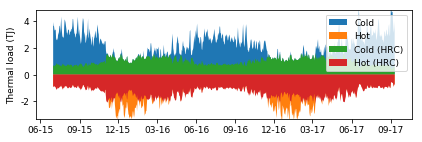

In [5]:
figure1(df)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


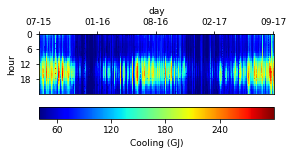

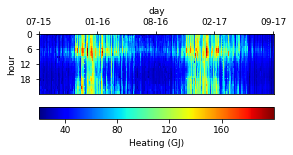

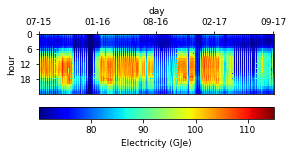

In [6]:
plot_energy_in_hmaps(df)